# Train a Medical Specialty Detector on SageMaker Using HuggingFace Transformers.

In this workshop, we will show how you can train an NLP classifier using trainsformers from [HuggingFace](https://huggingface.co/). HuggingFace allows for easily using prebuilt transformers, which you can train for your own use cases. 

In this workshop, we will use the SageMaker HuggingFace supplied container to train an algorithm that will distinguish between physician notes that are either part of the General Medicine (encoded as 0), or Radiology (encoded as 1) medical specialties. The data is a subsample from [MTSamples](https://www.mtsamples.com/) which was downloaded from [here](https://www.kaggle.com/tboyle10/medicaltranscriptions).

In [46]:
import json
from get_dependencies import get_dependencies
get_dependencies()

Finding Dependencies to Install
0 dependencies to install
Done Getting Dependencies


In [47]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import sagemaker
from sklearn.model_selection import train_test_split
pd.set_option('max_colwidth', 500) # to allow for better display of dataframes
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
BUCKET=sagemaker_session.default_bucket()
PREFIX='mtsample_speciality_prediction'

## Read in data and examine sample data
First we will read in the data; we will then copy it to S3.

In [49]:
df_1=pd.read_csv('MTsample_input_data.csv')
print(f'''The data has {df_1.shape[0]} rows''')
X_train, X_test = train_test_split(df_1, test_size=0.3)
X_train.to_csv('train.csv')
X_test.head(2)

The data has 199 rows


,specialty_encoded,text
17,0,"CHIEF COMPLAINT:, Altered mental status.,HISTORY OF PRESENT ILLNESS:, The patient is a 69-year-old male transferred from an outlying facility with diagnosis of a stroke. History is taken mostly from the emergency room record. The patient is unable to give any history and no family member is present for questioning. When asked why he came to the emergency room, the patient replies that it started about 2 PM yesterday. However, he is unable to tell me exactly what started at 2 PM yesterday. Th..."
1,0,"SUBJECTIVE:, This is an 11-year-old female who comes in for two different things. 1. She was seen by the allergist. No allergies present, so she stopped her Allegra, but she is still real congested and does a lot of snorting. They do not notice a lot of snoring at night though, but she seems to be always like that. 2. On her right great toe, she has got some redness and erythema. Her skin is kind of peeling a little bit, but it has been like that for about a week and a half now.,PAST..."


In [50]:
!aws s3 cp train.csv  s3://$BUCKET/$PREFIX/ #Copy the data to S3

upload: ./train.csv to s3://sagemaker-us-east-1-111918798052/mtsample_speciality_prediction/train.csv


## Configure the SageMaker training job
We will leverage the SageMaker provided container definition to build and train the transformer. In this approach we specify our training script (`train.py`) but rely on the SageMaker HuggingFace container.

For more information, see [here](https://docs.aws.amazon.com/sagemaker/latest/dg/hugging-face.html) and [here](https://huggingface.co/docs/sagemaker/main).


In [51]:
from sagemaker.huggingface import HuggingFace

# hyperparameters which are passed to the training job
hyperparameters={}

# create the Estimator
huggingface_estimator = HuggingFace(
        entry_point='train.py',
        instance_type='ml.p2.xlarge',
        instance_count=1,
        role=role,
        transformers_version='4.11.0',
        tensorflow_version='2.5.1',
        py_version='py37',
        hyperparameters = hyperparameters
)

In [52]:
!pygmentize train.py #specify our training script

import pandas as pd
import tensorflow as tf
import transformers
import argparse
import os
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--n_gpus", type=

Now train the model by calling the `fit` method.

In [ ]:
huggingface_estimator.fit(
  {'train': f's3://{BUCKET}/{PREFIX}/train.csv'}
)

## Deploy the Model as an endpoint
Now we will deploy the model as an endpoint, which can be queried with independent data.

In [54]:
endpoint=huggingface_estimator.deploy(1,"ml.g4dn.xlarge")

-----!

## Invoke the endpoint with test data
We will pass some holdout data to the endpoint to get an estimate of performance.

In [55]:
from sagemaker.serializers import JSONSerializer
my_serializer=JSONSerializer()
my_predictor=sagemaker.predictor.Predictor(endpoint.endpoint_name,sagemaker_session=sagemaker_session,serializer=my_serializer)
the_inputs=X_test['text'].tolist()

all_results=[]
for i in range(0,len(the_inputs)):
    the_input= the_inputs[i][0:512] #truncate to 512 characters
    the_result=my_predictor.predict({"inputs":the_input})
    all_results.append(the_result)
print(all_results[0]) # see what one result looks like.
#if the predicted label is negative normalize subtract it from 1, 
#so that lower scores mean predictions of General Medicine, and higher scores mean prediction of Radioligy.
all_results_2=[]
for i in all_results:
    the_result= json.loads(i)[0]
    the_score=the_result['score']
    the_label=the_result['label']
    if the_label=="NEGATIVE":
        all_results_2.append(1-the_score)
    else:
        all_results_2.append(the_score)


b'[{"label":"NEGATIVE","score":0.9815235733985901}]'


Measure the performance using a ROC curve.

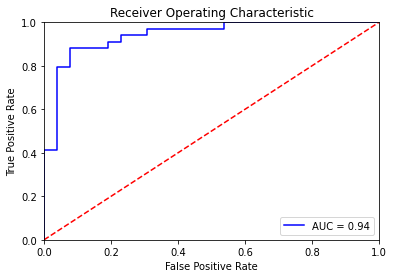

In [56]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds=all_results_2
fpr, tpr, threshold = metrics.roc_curve(X_test['specialty_encoded'].tolist(), preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Note that due to the fact that this is a small dataset, you may get a performance of .95 or even higher.